Visual comparison before and after of a single trained (and test) inputs

### Setup

In [ ]:
"""
    latentclustering.py
    
    Contains the model used for clustering in the latent space
    Note:
    - don't increase the threshold as it fails to retain the contextual information in the new embedding space (re-evaluate the optimizer)
    
"""

# TODO:
# - add a check point to store the last trained inputs' embeddings
# - add a path to save Neighbourhood

import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F

from functools import wraps
from collections import namedtuple 

from sentence_transformers import SentenceTransformer 

Cosmos = namedtuple('Cosmos', ['mean', 'min', 'max', 'std'])
Stash = namedtuple('Stash', ['query', 'latent', 'compressed'])

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

INPUT_DIM = 768 
HIDDEN_DIM = 512
OUTPUT_DIM = 1
MAX_ITER = 10
threshold = 1.0
model_card = "all-mpnet-base-v2"

class galaxy:
    """Wrapper function to view the statistics of the embeddings during training updates"""
    @staticmethod
    def _monitor(result: torch.tensor, data_name: str = None):
        data_name = data_name if data_name is not None else "test"
        print(f"Statistics for {data_name}:")
        print(f"Mean: {result.mean().item()}")
        print(f"Min: {result.min().item()}")
        print(f"Max: {result.max().item()}")
        print(f"Std Dev: {result.std().item()}")
        print("-" * 30)

    @staticmethod
    def monitor(func):
        @wraps(func)
        def wrapper(self, inputs: torch.tensor, green: torch.tensor, red: torch.tensor):
            print(f"Neighbourhood Shape input for inputs: {inputs.shape}, hit: {green.shape}, kill: {red.shape}")
            inputs, green, red, red_loss = func(self, inputs, green, red)
            output = {
                'inputs': inputs,
                'green': green,
                'red': red
            }
            # Print statistics
            for data_name, result in output.items():
                galaxy._monitor(result, data_name)
            
            return inputs, green, red, red_loss
        return wrapper

    @staticmethod
    def moonphase(func):
        @wraps(func)
        def wrapper(self, *args, **kwargs):
            """Wraps around network during eval mode. This only returns the statistics for one test sample (query)."""
            # Call the original function
            print("\nTesting with unseen data query . . .")
            result = func(self, *args, **kwargs)
            galaxy._monitor(result)
            return
        
        return wrapper

class LossAndFound(nn.Module):
    """
    A custom loss module that computes loss based on a 'hit list' and 'kill list' with respect to a 'wait list'.
    The goal is to penalize the difference between the wait list and the hit list while encouraging the distance
    between the wait list and the kill list.

    Attributes:
        beacon (float): A margin value to control how much of a difference between hit and kill lists is needed 
                        before applying penalties.
    """
    def __init__(self, alpha: float = 0.5):
        """
        Initializes the LossAndFound module with a beacon value that defines the margin for calculating loss.

        Args:
            alpha (float): The margin value for loss calculation. Default is 0.5.
        """
        super(LossAndFound, self).__init__()
        self.beacon = alpha  
        self.to(device)

    def forward(self, inputs: torch.Tensor, green: torch.Tensor, red: torch.Tensor) -> torch.Tensor:
        """
        Computes the loss between the wait list, hit list, and kill list using L2 norm. The final loss is the
        maximum of zero and the difference between the hit loss and kill loss plus the beacon margin.

        Args:
            inputs (torch.Tensor): A tensor representing the inputs tensor 
            green (torch.Tensor): A tensor representing the points where the distance to the inputs is minimized.
            red (torch.Tensor): A tensor representing the points where the distance to the inputs is maximized.

        Returns:
            final_loss (torch.Tensor): The computed final loss.
            green_loss (torch.Tensor): The L2 loss between the green and target inputs.
            red_loss (torch.Tensor): The L2 loss between the red and target inputs.

        Raises:
            AssertionError: If the input tensors do not have matching shapes.
        """
        assert inputs.shape ==  green.shape and green.shape == red.shape, f"Expected all inputs to be of the same shape: {inputs.shape}, {green.shape} and {red.shape}"
        
        inputs, green, red = inputs.squeeze(0), green.squeeze(0), red.squeeze(0)
        green_loss = torch.norm((inputs - green), p=2, dim=0)
        red_loss = torch.norm((inputs - red), p=2, dim=0)
        final_loss = torch.max(torch.tensor(0.0, device=green_loss.device), green_loss - red_loss + self.beacon)
        print(f"Final Loss: {final_loss}\t Hit loss: {green_loss}\t Kill loss: {red_loss}")
        return final_loss, green_loss, red_loss
    
class Neighbourhood(nn.Module):
    """
    A custom neural network module that projects input data to a hidden space and computes loss using a 
    custom loss function (e.g., LossAndFound - essentially the triplet margin loss). The embeddings were compressed to space of fewer dimensions (ie: 768 -> 512)

    Attributes:
        ball (nn.Linear): A linear layer mapping from input dimensions to hidden dimensions.
        loss (nn.Module): A custom loss function, typically LossAndFound.
        opt (torch.optim.Optimizer): The optimizer for training the model, using the Adam algorithm.
    """
    def __init__(self, input_dim: int = INPUT_DIM, hidden_dim: int = HIDDEN_DIM, output_dim: int = OUTPUT_DIM, loss_fn: nn.Module = LossAndFound):
        """
        Initializes the Neighbourhood module with specified input, hidden, and output dimensions. Also initializes
        the loss function and the optimizer.

        Args:
            input_dim (int): The size of the input feature dimension. Default is INPUT_DIM.
            hidden_dim (int): The size of the hidden layer dimension. Default is HIDDEN_DIM.
            output_dim (int): The size of the output layer dimension. Default is OUTPUT_DIM.
            loss_fn (nn.Module): The loss function to be used for training. Default is LossAndFound.
        """
        super(Neighbourhood, self).__init__()
        self.ball = nn.Linear(input_dim, hidden_dim, device=device)
        # self.grp = nn.Linear(hidden_dim, output_dim, device=device)
        self.loss = loss_fn()
        self.opt: torch.optim = optim.Adam(self.parameters(), lr=0.001)
        self.to(device)

    @galaxy.monitor
    def forward(self, inputs: torch.tensor, hit_input: torch.tensor = None, kill_input: torch.tensor = None):
        """
        Forward pass of the Neighbourhood network. In training mode, it computes the projection of the inputs, 
        computes the loss using the custom loss function, and updates the model parameters using backpropagation. 
        In evaluation mode, it simply returns the projection of the inputs. 

        Args:
            inputs (torch.tensor): The input tensor with a shape of [1, 768], representing the features to be processed.
            hit_input (torch.tensor, optional): The positive example tensor with the same shape as the input tensor. 
                                                Required during training to compute the loss. Default is None.
            kill_input (torch.tensor, optional): The negative example tensor with the same shape as the input tensor. 
                                                 Required during training to compute the loss. Default is None.

        Returns:
            If in training mode:
                - x (torch.tensor): The projection of the input.
                - pos (torch.tensor): The projection of the positive example.
                - neg (torch.tensor): The projection of the negative example.
                - red_loss (torch.tensor): The reduced loss computed by the loss function.
            
            If not in training mode:
                - torch.tensor: The projection of the input tensor after applying tanh activation.

        Raises:
            AssertionError: If the input tensors do not have the correct dimensions or if the input, hit_input, 
                            and kill_input do not have matching sizes during training.
        """
        assert inputs.size() == torch.Size([1, 768])
        if self.train:
            assert inputs.size() == hit_input.size() and inputs.size() == kill_input.size(), f"Input, inputs and kill input sizes are different: {inputs.size()}, {hit_input.size()}, {kill_input.size()}"
            self.opt.zero_grad()
            x = self.ball(inputs).tanh()
            pos = self.ball(hit_input).tanh()
            neg = self.ball(kill_input).tanh()
            loss, _, red_loss = self.loss(x, pos, neg)
            loss.backward()
            self.opt.step()
            return x, pos, neg, red_loss
        else:
            return self.ball(inputs).tanh()
            
class Basement(SentenceTransformer):
    """Subclass of SentenceTransformer. This is used to mean pool the queries' embeddings prior to running the embeddings through my custom network."""
    def __init__(self, model_card: str = "all-mpnet-base-v2"):
        super().__init__(model_card, device=device)
        # self.encode(args, convert_to_tensor=True, device=device)

class Stadium:
    """Unnecessary class to initiate this experiment's workflow"""
    def __init__(self, model_card: str = model_card, **kwargs: dict):
        self.base = Basement(model_card)
        self.model = Neighbourhood(**kwargs)
        self.backpack = []
        
    def update(self, *args: tuple, threshold: float = threshold, max_iter: float = MAX_ITER):
        """To train the Neighbourhood model."""
        assert len(args) == 3, f"Expected 3 str inputs for inputs, green, and red but received {len(args)}"
        self.model.train()
        inputs, green, red = self.base.encode(args, convert_to_tensor=True, device=device)
        inputs, green, red = inputs.unsqueeze(0), green.unsqueeze(0), red.unsqueeze(0)
        for ep in range(max_iter):
            new_emb, green_emb, red_emb, red_loss = self.model(inputs, green, red)
            if red_loss >= threshold:
                break
        """
        self.stash = {
            'target': Cosmos(mean=new_emb.mean(), min=new_emb.min(), max=new_emb.max(), std=new_emb.std()),
            'green': Cosmos(mean=green_emb.mean(), min=green_emb.min(), max=green_emb.max(), std=green_emb.std()),
            'red': Cosmos(mean=red_emb.mean(), min=red_emb.min(), max=red_emb.max(), std=red_emb.std())
        }
        """
        self.backpack += [{
            'target': Stash(query=args[0], latent=inputs, compressed=new_emb),
            'green': Stash(query=args[1], latent=green, compressed=green_emb),
            'red': Stash(query=args[-1], latent=red, compressed=red_emb)
        }]

        print(f"Training finished after {ep} steps\n")

    @galaxy.moonphase
    def evaluate(self, unseen: str):
        """Evaluate the model with unseen dataset"""
        self.model.eval()
        embedding = self.base.encode([unseen], convert_to_tensor=True, device=device)

        with torch.no_grad():
            output= self.model.ball(embedding).tanh()

        # experimenting autolabelling task
        last_seen = self.backpack[-1]
        diff_target = torch.cdist(last_seen['target'].compressed, output)
        diff_green = torch.cdist(last_seen['green'].compressed, output)
        diff_red = torch.cdist(last_seen['red'].compressed, output)

        l1prob = torch.stack([(diff_target + diff_green) / 2, diff_red], dim=1) 
        l1prob /= l1prob.sum()
        print(f"Green: {diff_green.flatten()[0]}\t Red: {diff_red.flatten()[0]} \t\t V: {l1prob.flatten().detach().cpu().numpy()}")
        
        return output 
    
if __name__ == "__main__":
    # import pandas as pd
    # initial_data = pd.read_parquet("hf://datasets/dair-ai/emotion/unsplit/train-00000-of-00001.parquet")
    input_query = "I love you so much"
    pos_query = "Yeah I fuck with you man"
    neg_query = "I fucking hate you"
    
    space = Stadium(model_card=model_card)
    space.update(input_query, pos_query, neg_query)

    unseen_query = "I like you"
    space.evaluate(unseen=unseen_query)

/opt/homebrew/Caskroom/miniforge/base/envs/garfield/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/opt/homebrew/Caskroom/miniforge/base/envs/garfield/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Neighbourhood Shape input for inputs: torch.Size([1, 768]), hit: torch.Size([1, 768]), kill: torch.Size([1, 768])
Final Loss: 0.5226855278015137	 Hit loss: 0.5917112231254578	 Kill loss: 0.5690256953239441
Statistics for inputs:
Mean: -0.0005490270559675992
Min: -0.08766394853591919
Max: 0.07680537551641464
Std Dev: 0.030533403158187866
------------------------------
Statistics for green:
Mean: -0.0006968661909922957
Min: -0.06773221492767334
Max: 0.08500862121582031
Std Dev: 0.029832899570465088
------------------------------
Statistics for red:
Mean: 3.4962547942996025e-05
Min: -0.09348252415657043
Max: 0.08429517596960068
Std Dev: 0.032089199870824814
------------------------------
Neighbourhood Shape input for inputs: torch.Size([1, 768]), hit: torch.Size([1, 768]), kill: torch.Size([1, 768])
Final Loss: 0.01601719856262207	 Hit loss: 0.3922461271286011	 Kill loss: 0.876228928565979
Statistics for inputs:
Mean: -0.0008093171054497361
Min: -0.08522503077983856
Max: 0.076862931251525

In [ ]:
last_seen = space.backpack[-1]

In [ ]:
unseen_embed = space.evaluate(unseen=unseen_query)


Testing with unseen data query . . .
Green: 0.6328327059745789	 Red: 0.6070065498352051 		 V: [0.55004156 0.4499584 ]
Statistics for test:
Mean: -0.0009082467295229435
Min: -0.08511900901794434
Max: 0.08200383931398392
Std Dev: 0.033668797463178635
------------------------------


In [ ]:
before_target = last_seen['target'].latent.squeeze().cpu().detach().numpy()  # Detach from computation graph
after_target = last_seen['target'].compressed.squeeze().cpu().detach().numpy()  # Detach from computation graph

In [ ]:
before_x = np.random.normal(before_target.mean(), before_target.std(), size=(100,))
after_x = np.random.normal(after_target.mean(), after_target.std(), size=(100,))

## Visualise

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
before_green = np.random.normal(loc=last_seen['green'].latent.mean().item(), scale=last_seen['green'].latent.std().item(), size=(100,))
before_red = np.random.normal(loc=last_seen['red'].latent.mean().item(), scale=last_seen['red'].latent.std().item(), size=(100,))
after_green = np.random.normal(loc=last_seen['green'].compressed.mean().item(), scale=last_seen['green'].compressed.std().item(), size=(100,))
after_red = np.random.normal(loc=last_seen['red'].compressed.mean().item(), scale=last_seen['red'].compressed.std().item(), size=(100,))

**Density before compression**

<Axes: ylabel='Density'>

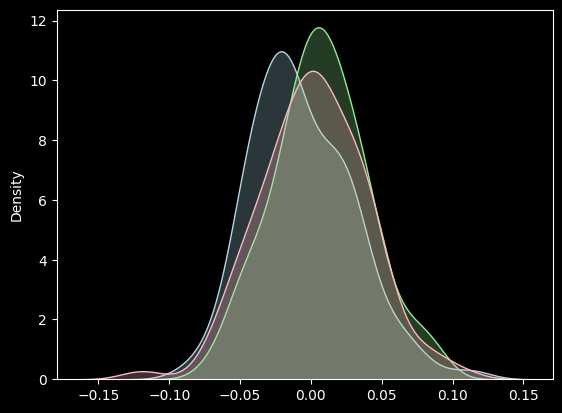

In [ ]:
sns.kdeplot(before_x, label='Target', color='lightblue', fill=True)
sns.kdeplot(before_green, label='Green', color='lightgreen', fill=True)
sns.kdeplot(before_red, label='Red', color='lightpink', fill=True)

**Density after compression**

<Axes: ylabel='Density'>

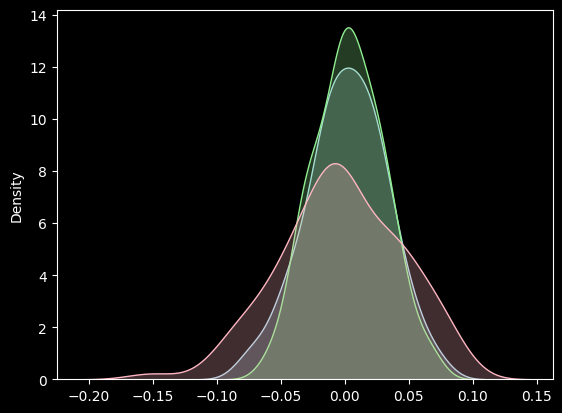

In [ ]:
sns.kdeplot(after_x, label='Target', color='lightblue', fill=True)
sns.kdeplot(after_green, label='Green', color='lightgreen', fill=True)
sns.kdeplot(after_red, label='Red', color='lightpink', fill=True)

**Target's density before and after**

<Axes: ylabel='Density'>

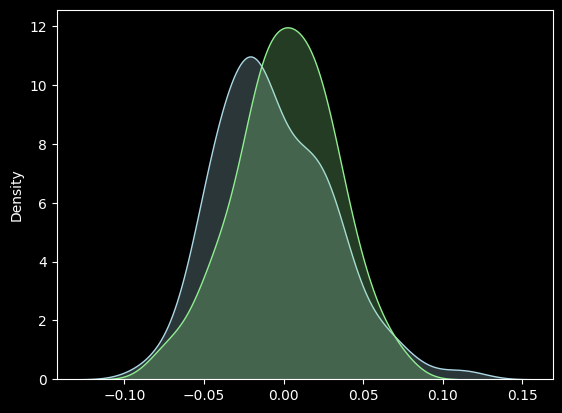

In [ ]:
sns.kdeplot(before_x[:100], label='before', color='lightblue', fill=True)
sns.kdeplot(after_x[:100], label='After', color='lightgreen', fill=True)

In [ ]:
a = last_seen['target'].latent.squeeze().cpu().detach().numpy() 
b = last_seen['green'].latent.squeeze().cpu().detach().numpy() 
c = last_seen['red'].latent.squeeze().cpu().detach().numpy() 
stacks = np.vstack([a, b, c])

**After encoding unseen**

<Axes: ylabel='Density'>

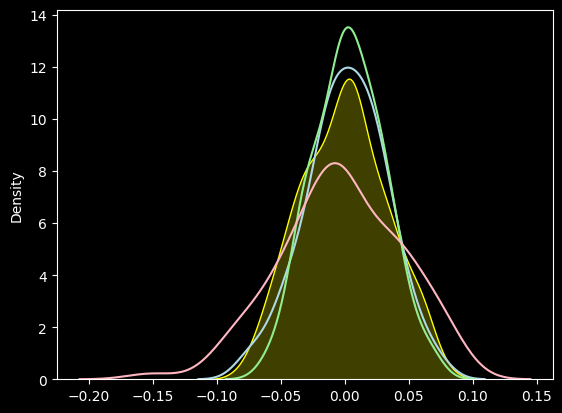

In [ ]:
sns.kdeplot(after_x, label='Target', color='lightblue', fill=False)
sns.kdeplot(after_green, label='Green', color='lightgreen', fill=False)
sns.kdeplot(after_red, label='Red', color='lightpink', fill=False)
# unseen_embed = evaluate(space, unseen_query)
sns.kdeplot(unseen_embed.squeeze().cpu().detach().numpy(), label='Unseen', color='yellow', fill=True)

**Before encoding unseen query**

In [ ]:
before_unseen = space.base.encode([unseen_query])

<Axes: ylabel='Density'>

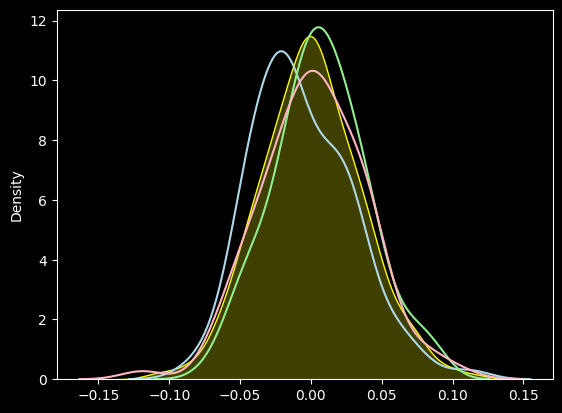

In [ ]:
sns.kdeplot(before_x, label='Target', color='lightblue', fill=False)
sns.kdeplot(before_green, label='Green', color='lightgreen', fill=False)
sns.kdeplot(before_red, label='Red', color='lightpink', fill=False)
sns.kdeplot(before_unseen.reshape(-1), label='Unseen', color='yellow', fill=True)